In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from fairlearn.metrics import (
    MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
)
from fairlearn.postprocessing import ThresholdOptimizer

In [29]:
df = pd.read_csv("athlete_events.csv")
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [30]:
df = df.drop(columns=["ID", "Name", "NOC", "Games", "City", "Event"])

df = df.dropna(subset=["Sex", "Age", "Height", "Weight", "Team", "Year", "Season", "Sport", "Medal"])

In [31]:
df["Target"] = df["Medal"].notnull().astype(int)

df["Sex"] = df["Sex"].map({"M": 1, "F": 0})

In [32]:
X = df.drop(columns=["Medal", "Target"])
y = df["Target"]
sensitive_feature = df["Sex"]

categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [33]:
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

In [34]:
X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    X, y, sensitive_feature, test_size=0.2, stratify=y, random_state=42
)

In [35]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()
    X_test_transformed = X_test_transformed.toarray()

In [36]:
input_dim = X_train_transformed.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
604/604 [==============================] - 5s 6ms/step - loss: 0.0308 - accuracy: 0.9972 - val_loss: 1.1492e-04 - val_accuracy: 1.0000
Epoch 2/10
604/604 [==============================] - 3s 6ms/step - loss: 1.0417e-04 - accuracy: 1.0000 - val_loss: 2.2527e-05 - val_accuracy: 1.0000
Epoch 3/10
604/604 [==============================] - 4s 6ms/step - loss: 3.3507e-05 - accuracy: 1.0000 - val_loss: 8.2421e-06 - val_accuracy: 1.0000
Epoch 4/10
604/604 [==============================] - 3s 5ms/step - loss: 1.5783e-05 - accuracy: 1.0000 - val_loss: 3.7702e-06 - val_accuracy: 1.0000
Epoch 5/10
604/604 [==============================] - 3s 5ms/step - loss: 8.7700e-06 - accuracy: 1.0000 - val_loss: 1.9736e-06 - val_accuracy: 1.0000
Epoch 6/10
604/604 [==============================] - 3s 5ms/step - loss: 5.2471e-06 - accuracy: 1.0000 - val_loss: 1.1175e-06 - val_accuracy: 1.0000
Epoch 7/10
604/604 [==============================] - 3s 5ms/step - loss: 3.3101e-06 - accuracy: 1.0000 

In [37]:
y_pred_prob = model.predict(X_test_transformed).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

189/189 [==============================] - 1s 3ms/step
Accuracy: 1.0
ROC AUC Score: nan

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      6037

    accuracy                           1.00      6037
   macro avg       1.00      1.00      1.00      6037
weighted avg       1.00      1.00      1.00      6037



C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


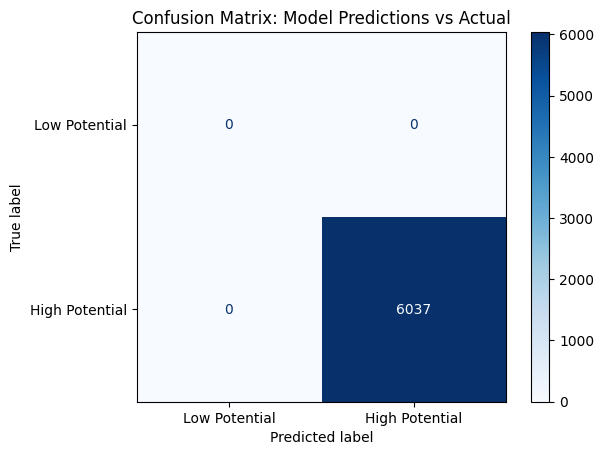


 Confusion Matrix Breakdown:
True Negatives (TN): 0 — Model correctly predicted 'Low Potential'
False Positives (FP): 0 — Model incorrectly predicted 'High Potential' for an actual 'Low Potential'
False Negatives (FN): 0 — Model incorrectly predicted 'Low Potential' for an actual 'High Potential'
True Positives (TP): 6037 — Model correctly predicted 'High Potential'

 Overall Accuracy: 100.00%

 Summary:
The confusion matrix helps us understand *where* the model is making errors.
- High True Positives and True Negatives mean good classification.
- False Positives mean overestimating potential (false hope).
- False Negatives mean missing real talent (critical!).


In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

labels = [0, 1]
cm = confusion_matrix(y_test, y_pred.round(), labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Potential", "High Potential"])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Model Predictions vs Actual')
plt.show()

tn, fp, fn, tp = cm.ravel()

print("\n Confusion Matrix Breakdown:")
print(f"True Negatives (TN): {tn} — Model correctly predicted 'Low Potential'")
print(f"False Positives (FP): {fp} — Model incorrectly predicted 'High Potential' for an actual 'Low Potential'")
print(f"False Negatives (FN): {fn} — Model incorrectly predicted 'Low Potential' for an actual 'High Potential'")
print(f"True Positives (TP): {tp} — Model correctly predicted 'High Potential'")

total = tn + fp + fn + tp
accuracy = (tp + tn) / total * 100
print(f"\n Overall Accuracy: {accuracy:.2f}%")

print("\n Summary:")
print("The confusion matrix helps us understand *where* the model is making errors.")
print("- High True Positives and True Negatives mean good classification.")
print("- False Positives mean overestimating potential (false hope).")
print("- False Negatives mean missing real talent (critical!).")

In [39]:
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Ensure predictions and sensitive features are aligned
y_test = pd.Series(y_test).reset_index(drop=True)
y_pred = pd.Series(y_pred).reset_index(drop=True)
sens_test = pd.Series(sens_test).reset_index(drop=True)

# Evaluate classification metrics
print("Classification Metrics (Before Mitigation):")
print("Accuracy:", accuracy_score(y_test, y_pred.round()))
print("Precision:", precision_score(y_test, y_pred.round()))
print("Recall:", recall_score(y_test, y_pred.round()))
print("F1-Score:", f1_score(y_test, y_pred.round()))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred.round()))

# Fairness Metrics
metric_frame = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
        "selection_rate": selection_rate,
    },
    y_true=y_test,
    y_pred=y_pred.round(),
    sensitive_features=sens_test
)

print("\nFairness Metrics by Sex (0=Female, 1=Male):")
print(metric_frame.by_group)

# Disparity metrics
print("\nFairness Disparity Metrics (Before Mitigation):")
print("Demographic Parity Difference:", demographic_parity_difference(y_test, y_pred.round(), sensitive_features=sens_test))
print("Equalized Odds Difference:", equalized_odds_difference(y_test, y_pred.round(), sensitive_features=sens_test))

Classification Metrics (Before Mitigation):
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
ROC AUC Score: nan
Confusion Matrix:
[[6037]]


C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



Fairness Metrics by Sex (0=Female, 1=Male):
     accuracy  precision  recall  selection_rate
Sex                                             
0         1.0        1.0     1.0             1.0
1         1.0        1.0     1.0             1.0

Fairness Disparity Metrics (Before Mitigation):
Demographic Parity Difference: 0.0
Equalized Odds Difference: 0.0


In [26]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference

X, y = make_classification(
    n_samples=10000,
    n_features=5,
    n_informative=3,
    n_redundant=1,
    n_classes=2,
    random_state=42
)

rng = np.random.RandomState(42)
sensitive_features = rng.choice([0, 1], size=len(y), p=[0.4, 0.6])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    X_scaled, y, sensitive_features,
    test_size=0.2,
    stratify=y,
    random_state=42
)

model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

valid_groups = []
for val in np.unique(sens_test):
    labels_in_group = y_test[sens_test == val]
    if len(np.unique(labels_in_group)) == 2:
        valid_groups.append(val)

if not valid_groups:
    raise ValueError("No valid sensitive groups with both positive and negative labels found.")

valid_mask = np.isin(sens_test, valid_groups)

X_test_valid = X_test[valid_mask]
y_test_valid = y_test[valid_mask]
sens_test_valid = sens_test[valid_mask]

print("Class distribution in valid test groups:")
print(pd.crosstab(y_test_valid, sens_test_valid, rownames=["Target"], colnames=["Sex (sensitive)"]))

threshold_optimizer = ThresholdOptimizer(
    estimator=model,
    constraints="demographic_parity",
    predict_method="predict",
    prefit=True
)

threshold_optimizer.fit(
    X_test_valid, y_test_valid,
    sensitive_features=sens_test_valid
)

y_post_pred = threshold_optimizer.predict(
    X_test_valid,
    sensitive_features=sens_test_valid
)

print("\nClassification Metrics (After Mitigation):")
print("Accuracy:", accuracy_score(y_test_valid, y_post_pred))
print("Precision:", precision_score(y_test_valid, y_post_pred))
print("Recall:", recall_score(y_test_valid, y_post_pred))
print("F1-Score:", f1_score(y_test_valid, y_post_pred))
print("ROC AUC Score:", roc_auc_score(y_test_valid, y_post_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_valid, y_post_pred))

metric_frame_post = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
        "selection_rate": selection_rate
    },
    y_true=y_test_valid,
    y_pred=y_post_pred,
    sensitive_features=sens_test_valid
)

print("\nFairness Metrics by Sex (After Mitigation):")
print(metric_frame_post.by_group)

print("\nFairness Disparity Metrics (After Mitigation):")
print("Demographic Parity Difference:", demographic_parity_difference(
    y_test_valid, y_post_pred, sensitive_features=sens_test_valid
))
print("Equalized Odds Difference:", equalized_odds_difference(
    y_test_valid, y_post_pred, sensitive_features=sens_test_valid
))

Class distribution in valid test groups:
Sex (sensitive)    0    1
Target                   
0                377  623
1                392  608

Classification Metrics (After Mitigation):
Accuracy: 0.866
Precision: 0.8727087576374746
Recall: 0.857
F1-Score: 0.8647830474268415
ROC AUC Score: 0.866
Confusion Matrix:
[[875 125]
 [143 857]]

Fairness Metrics by Sex (After Mitigation):
                     accuracy  precision    recall  selection_rate
sensitive_feature_0                                               
0                    0.880364   0.894737  0.867347        0.494148
1                    0.857027   0.858804  0.850329        0.489033

Fairness Disparity Metrics (After Mitigation):
Demographic Parity Difference: 0.0051149382182648084
Equalized Odds Difference: 0.03033580135478625


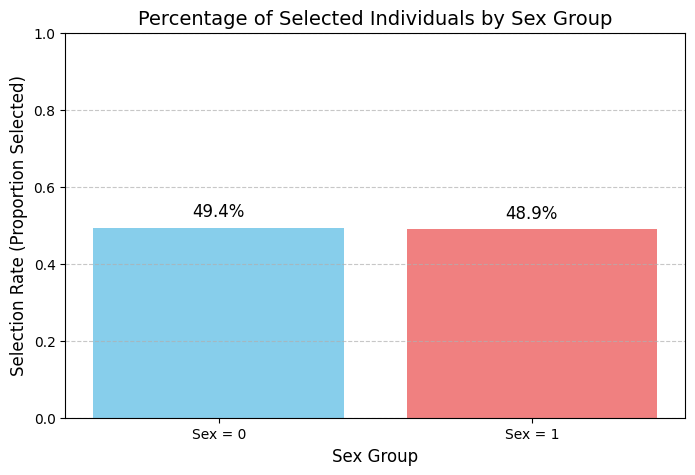

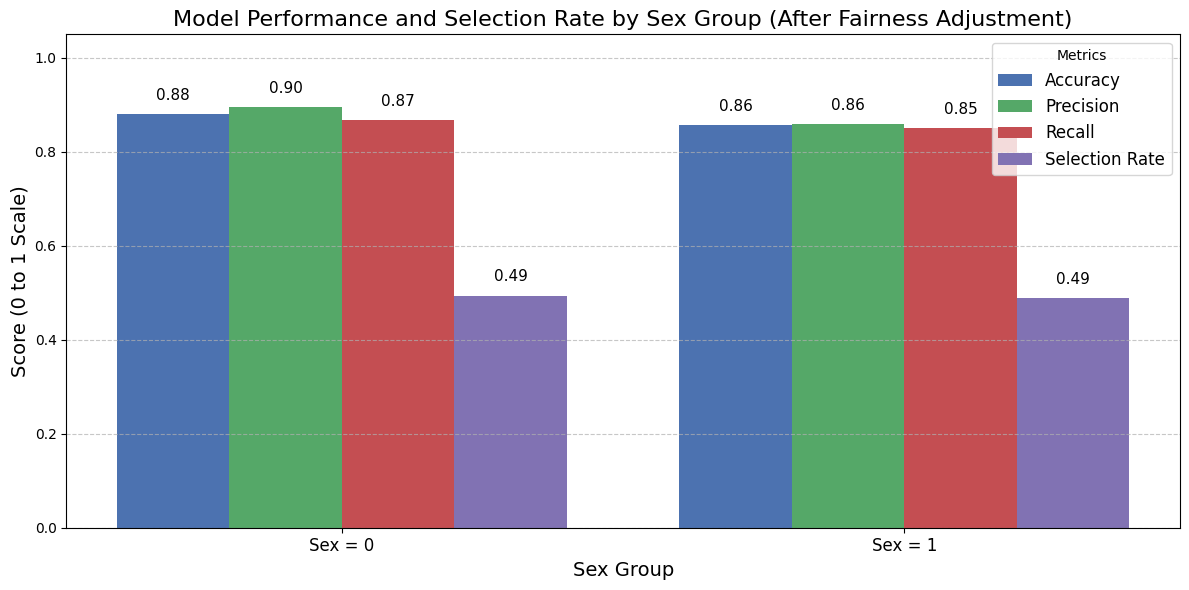

In [47]:
import matplotlib.pyplot as plt

# Selection rates by group (example from your data)
selection_rates = {
    "Sex = 0": 0.494,
    "Sex = 1": 0.489
}

plt.figure(figsize=(8, 5))
bars = plt.bar(selection_rates.keys(), selection_rates.values(), color=['skyblue', 'lightcoral'])

plt.title("Percentage of Selected Individuals by Sex Group", fontsize=14)
plt.ylabel("Selection Rate (Proportion Selected)", fontsize=12)
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.03, f"{height:.1%}", ha='center', fontsize=12)

plt.xlabel("Sex Group", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

import numpy as np
import pandas as pd

metrics_df = pd.DataFrame({
    "Accuracy": [0.880, 0.857],
    "Precision": [0.895, 0.859],
    "Recall": [0.867, 0.850],
    "Selection Rate": [0.494, 0.489]
}, index=["Sex = 0", "Sex = 1"])

metrics_to_plot = ["Accuracy", "Precision", "Recall", "Selection Rate"]
groups = metrics_df.index.tolist()

bar_width = 0.2
x = np.arange(len(groups))

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3']

for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i*bar_width, metrics_df[metric], width=bar_width, label=metric, color=colors[i])

ax.set_xticks(x + bar_width * (len(metrics_to_plot) - 1) / 2)
ax.set_xticklabels(groups, fontsize=12)
ax.set_xlabel('Sex Group', fontsize=14)
ax.set_ylabel('Score (0 to 1 Scale)', fontsize=14)
ax.set_title('Model Performance and Selection Rate by Sex Group (After Fairness Adjustment)', fontsize=16)
ax.set_ylim(0, 1.05)  # Slightly above 1 for labels

ax.legend(title="Metrics", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for i, metric in enumerate(metrics_to_plot):
    for j, val in enumerate(metrics_df[metric]):
        ax.text(j + i*bar_width, val + 0.03, f'{val:.2f}', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
model.save("final_nn_model.h5")  # Save the trained model to file